In [1]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [2]:
seconds_passed_vid = 24 # seconds
time_offset = -1 # seconds
seconds_passed_helicopter_gps = seconds_passed_vid + time_offset

In [3]:
sem_segm_img_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/2023_RVV_1_mask_24.jpg"
mapbox_imgs_dir_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/mapbox_images_for_frame_24_RVV1"
heli_lat = 50.78991333333333
heli_lon = 3.561253333333333
intersec_lat = 50.776677
intersec_lon = 3.525508
altitude = 158

In [4]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [6]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [7]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, heli_df) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    # result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    # print(f"Result: {result}")
    # if not result.empty:
    #    altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {altitude}")

    alpha_radian = math.atan2(altitude, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [8]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt) : 
    print(f"Getting image for intersection lat = {lat}, lon = {lon}")
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}"

    response = requests.get(url)

    if response.status_code == 200:
        with open(f"{lat}_{lon}.png", "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat}_{lon}.png")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [9]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [10]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)
print("Intersections:")
print(df_intersections)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]
print("Helicopter dataframe:")
print(heli_df)

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], heli_df)
    print(f"Pitch = {pitch}")
    # get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch)

Intersections:
         lat       lon
0  50.790495  3.561786
1  50.790134  3.563985
2  50.787813  3.560847
3  50.790311  3.560103
4  50.789609  3.560640
5  50.788729  3.564596
6  50.788882  3.563594
7  50.790018  3.558265
8  50.788939  3.563220
Helicopter dataframe:
            lat       lng     alt  seconds_from_start
0     50.775510  3.525282  157.52                 0.0
1     50.775488  3.525138  157.78                 0.0
2     50.775477  3.524995  157.80                 1.0
3     50.775475  3.524853  157.57                 2.0
4     50.775483  3.524715  157.21                 2.0
...         ...       ...     ...                 ...
4965  50.860450  3.701922  102.98              3254.0
4966  50.860553  3.702080  103.91              3254.0
4967  50.860648  3.702242  104.26              3255.0
4968  50.860737  3.702405  105.17              3256.0
4969  50.860778  3.702490  105.36              3256.0

[4970 rows x 4 columns]
Intersection: 50.7904954,3.5617855
Bearing = 30.026296444922

In [11]:
def get_skeleton(mask_bgr, contour) : 
    # print("Getting the skeleton and the pruned skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)
    contour_mask_bgr = cv2.cvtColor(contour_mask_gray, cv2.COLOR_GRAY2BGR)
    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh = threshold_otsu(contour_mask_gray)
    contour_mask_gray = contour_mask_gray > thresh
    
    # 1. Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_gray, method='lee').astype(np.uint8)

    np.set_printoptions(threshold=np.inf)
    # print("Skeleton image values:")
    # print(skeleton_gray)


    # plt.figure(figsize=(20,10))
    # plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    # plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [12]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # if we have a white pixel
            if image[x][y] == 1:
                neighbours = [image[x-1][y], image[x-1][y-1], image[x][y-1], image[x+1][y-1], image[x+1][y], image[x+1][y+1], image[x][y+1], image[x-1][y+1]]
                if neighbours in validIntersection:
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [13]:
def prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold) : 
    print("Pruning the skeleton")
    pruned_skeleton_contour_bgr = np.zeros_like(skeleton_contour_bgr) 
    bad_contours = []
    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr_help = skeleton_contour_bgr.copy()
        # cv2.circle(pruned_skeleton_contour_bgr_help, (intersection[0], intersection[1]), 1, (0,0,0), -1)
        pruned_skeleton_contour_bgr_help[intersection[1], intersection[0]] = (0,0,0)

        pruned_skeleton_contour_gray_help = cv2.cvtColor(pruned_skeleton_contour_bgr_help, cv2.COLOR_BGR2GRAY)
        contours, hierarchy = cv2.findContours(pruned_skeleton_contour_gray_help, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours : 
            if cv2.arcLength(contour, closed=False) > threshold :
                cv2.drawContours(pruned_skeleton_contour_bgr, [contour], contourIdx=-1, color=(255, 255, 255), thickness=1)
            else : 
                bad_contours.append(contour)

    for bad_contour in bad_contours :
        cv2.drawContours(pruned_skeleton_contour_bgr, [bad_contour], contourIdx=-1, color=(0, 0, 0), thickness=1)

    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr[intersection[1], intersection[0]] = (255,255,255)
    return pruned_skeleton_contour_bgr    

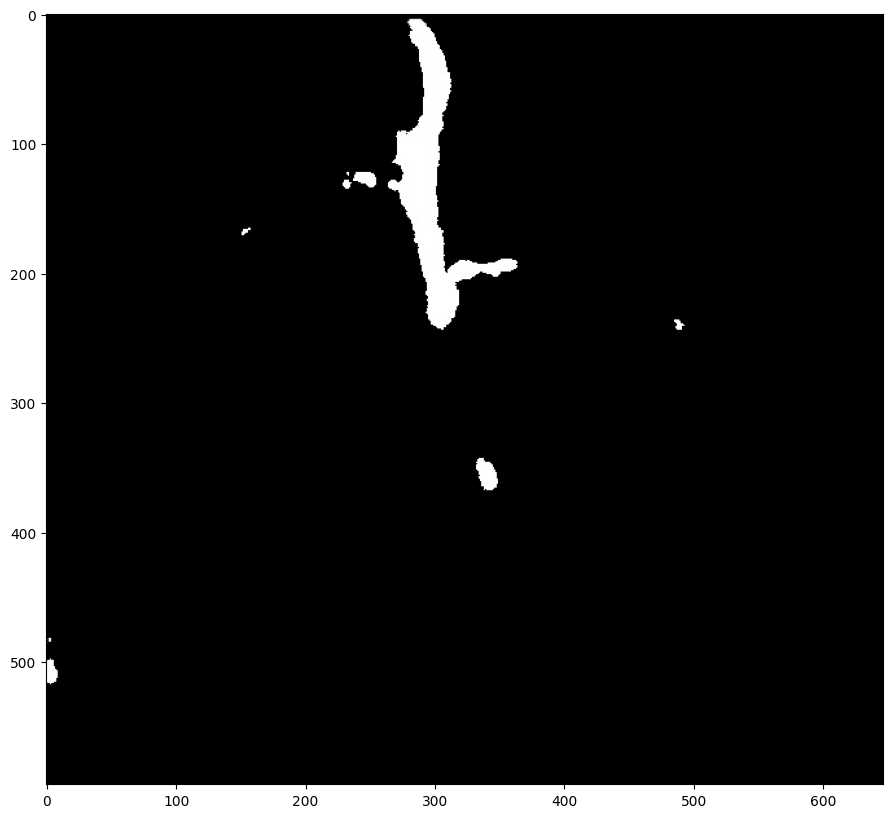

In [14]:
img_bgr = cv2.imread(sem_segm_img_path)
plot_image(img_bgr)

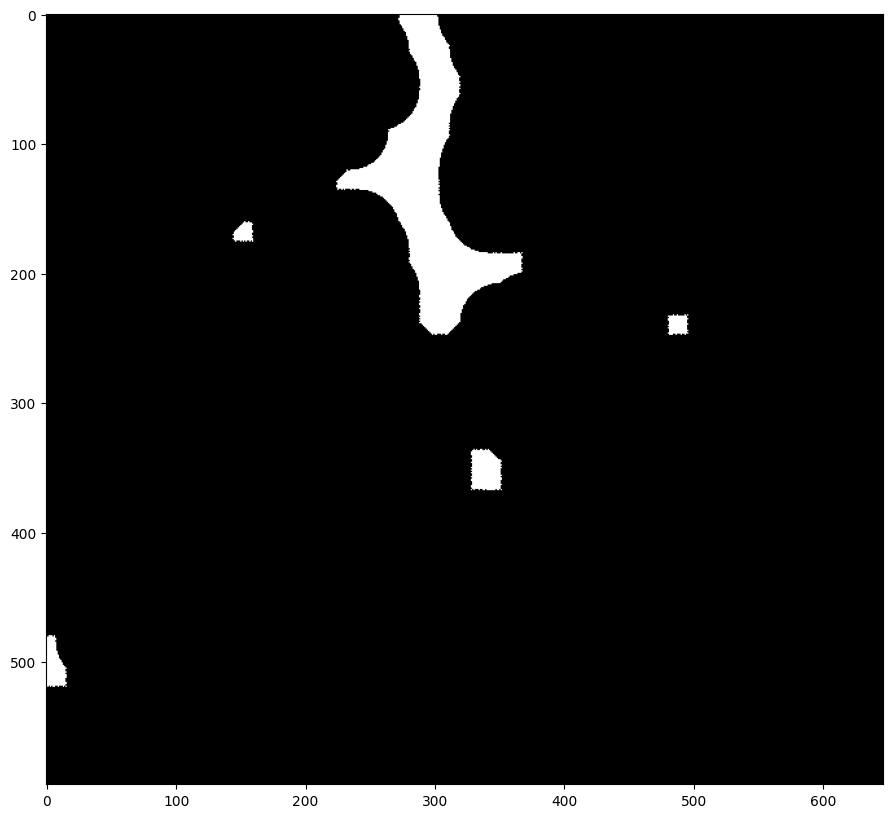

Shape of closing_bgr: (595, 647, 3)


In [15]:
closing_bgr = isotropic_closing(img_bgr, radius=30)
closing_bgr = closing_bgr.astype(np.uint8) * 255
plot_image(closing_bgr)
print(f"Shape of closing_bgr: {closing_bgr.shape}")

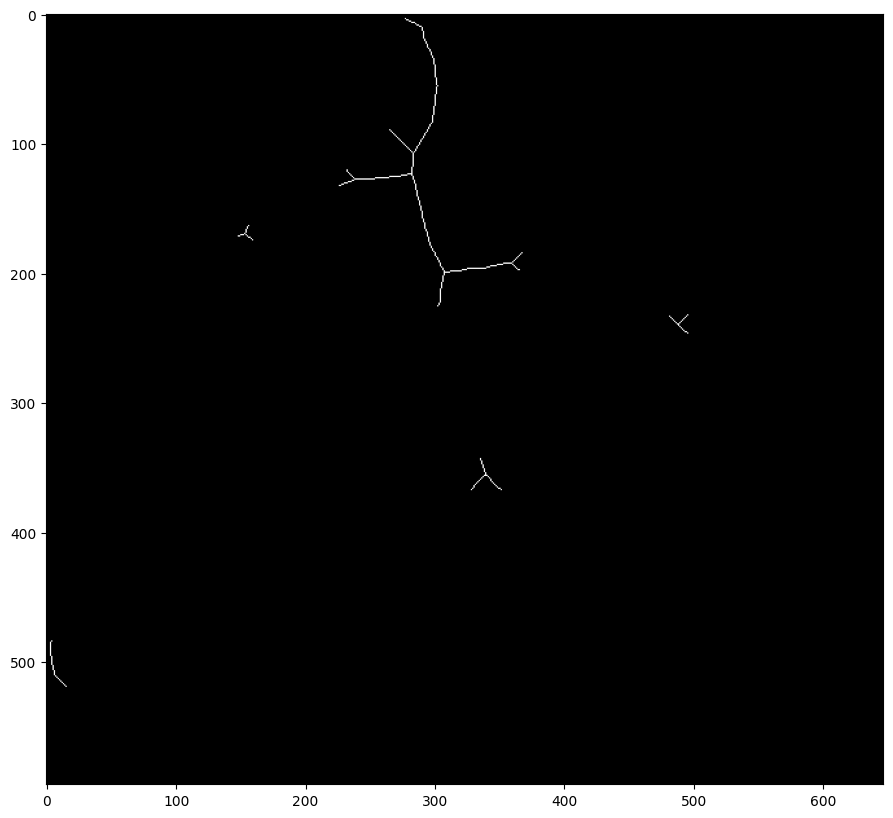

In [16]:
mask_bgr = closing_bgr.copy()
mask_bgr_copy = mask_bgr.copy()
mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)
mask_gray_copy = mask_gray.copy()
skeleton_gray = skeletonize(mask_gray)
skeleton_gray = skeleton_gray.astype(np.uint8) * 255
skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
plot_image(skeleton_bgr)

In [17]:
def get_patch_from_intersection(skel_contour_bgr, intersec, patch_size) : 
    # print("Getting patch from intersection")
    skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate the coordinates of the patch boundaries
    x, y = intersec[0], intersec[1]
    x_min, x_max = x - patch_size // 2, x + patch_size // 2 + 1
    y_min, y_max = y - patch_size // 2, y + patch_size // 2 + 1

    # Ensure the coordinates are within the image bounds
    x_min = max(0, x_min)
    x_max = min(skel_contour_gray.shape[1], x_max)
    y_min = max(0, y_min)
    y_max = min(skel_contour_gray.shape[0], y_max)

    # Extract the patch
    patch = skel_contour_gray[y_min:y_max, x_min:x_max]

    # Patch intersection value
    patch_intersection = (patch.shape[0]//2, patch.shape[1]//2)

    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            if patch[patch_intersection[1]+y, patch_intersection[0]+x] == 255 and (x != 0 or y != 0):
                road_neighbour_pixels.append((patch_intersection[0]+x, patch_intersection[1]+y))

    return patch, road_neighbour_pixels

In [18]:
def find_road_pixels(patch, reference_pixel, neighbour_pixels, intersection, visited_pixels=None):
    if visited_pixels is None:
        visited_pixels = set()

    # print("Finding road pixels")
    # print(f"Intersection = {intersection}")
    patch_size = patch.shape[0]
    road_pixels = []

    for x in range(-1, 2):
        for y in range(-1, 2):
            pixel = (reference_pixel[0] + x, reference_pixel[1] + y)

            # Check if the pixel has been visited or is out of bounds
            if pixel[0] < 0 or pixel[0] >= patch_size or pixel[1] < 0 or pixel[1] >= patch_size or pixel in visited_pixels:
                continue

            # Check if the pixel is a road pixel and not the intersection itself
            if patch[pixel[1], pixel[0]] == 255 and (x != 0 or y != 0) and pixel != intersection and pixel not in neighbour_pixels:
                road_pixels.append(pixel)
                visited_pixels.add(pixel)
                # Recursively search from this pixel
                road_pixels += find_road_pixels(patch, pixel, neighbour_pixels, intersection, visited_pixels)
    
    return road_pixels


In [19]:
def get_descriptor(patch, neighbour_pixels) : 
    # For visualisation purposes
    patch_bgr = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
    
    # Find intersection and set value to 0
    intersection = (patch.shape[0]//2, patch.shape[1]//2)
    patch[intersection[0], intersection[1]] = 0

    angles_vector = []
    
    
    
    # if lines is None : 
    #     print("No houghlines found")
    # else :
    #     for i in range(0, len(lines)):
    #         rho = lines[i][0][0]
    #         theta = lines[i][0][1]
    #         a = math.cos(theta)
    #         b = math.sin(theta)
    #         x0 = a * rho
    #         y0 = b * rho
    #         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    #         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    #         cv2.line(patch_bgr, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

    # print("Patch with houghlines")
    # plot_image(patch_bgr)

    for neighbour_pixel in neighbour_pixels :
        road_pixels = find_road_pixels(patch, neighbour_pixel, neighbour_pixels, intersection, None)
        road_pixels.append(neighbour_pixel)
        road_pixels.append(intersection)
        print(f"Road pixels for neighbour pixel {neighbour_pixel} (including intersection): ")
        # print(road_pixels)

        # now append the neighbour pixel AND the intersection pixel to the road pixels 
        # road_pixels.append(intersection)

        # Switch y values because the y axis is inverted
        road_pixels = [(pixel[0], (patch.shape[0]-1) - pixel[1]) for pixel in road_pixels]

        # Adjust the coordinates of road pixels and intersection to be relative to the center
        adjusted_road_pixels = [(pixel[0] - intersection[0], pixel[1] - intersection[1]) for pixel in road_pixels]

        # convert to numpy array
        road_pixels = np.array(adjusted_road_pixels, dtype=np.float32)
        print(f"Road pixels after adjustment (intersection is now origin): ")
        print(road_pixels)


        # For each set of coordinates, compute the best-fit line
        x_values = np.array([coord[0] for coord in road_pixels])
        y_values = np.array([coord[1] for coord in road_pixels])
  

        # Check if all x-values are the same
        all_x_values_same = all(x == x_values[0] for x in x_values)
        if all_x_values_same :
            if neighbour_pixel[1] > intersection[1] :
                angle = 270
            else :
                angle = 90
            angles_vector.append(angle)
            continue

        line = np.polyfit(x_values, y_values, deg=1)
        
        print(f"Line: {line}")

        # Now show the line on the patch
        a = line[0]
        b = line[1]
        y = a * x_values + b
        plt.plot(x_values, y)
        plt.show()

        # The slope of each line gives the direction of the road segment it fits
        angle = np.degrees(np.arctan(a))

        if angle > 0 :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] > intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
        else :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] < intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
            else : 
                angle = angle + 360

        print(f"Direction is: {angle}")
        angles_vector.append(angle)

        # Calculate the direction vector

        # Fit lines using the points
        # vx, vy, x0, y0 = cv2.fitLine(road_pixels, cv2.DIST_L2, 0, 0.01, 0.01)
        # print(f"vx = {vx}, vy = {vy}, x0 = {x0}, y0 = {y0}")

        # direction_vector = (vx[0], vy[0])

        # # Calculate the angle in radians
        # angle_radians = math.atan2(vy[0], vx[0])

        # # Convert the angle to degrees
        # angle_degrees = math.degrees(angle_radians)

        # print(f"Angle: {angle_degrees} degrees")

        # direction_vectors.append(direction_vector)
    
    # print(f"Direction vectors: {angles_vector}")
    # sort direction_vectors from small to big
    angles_vector_sorted = sorted(angles_vector)
    print(f"Sorted vector of angles: {angles_vector_sorted}")

    descriptor = angles_vector_sorted

    # descriptor = []
    # # define a descriptor based on angles_vector_sorted
    # for i in range(1, len(angles_vector_sorted)): 
    #     angle_ratio = angles_vector_sorted[i] / angles_vector_sorted[0]
    #     descriptor.append(angle_ratio) 
        
    # print(f"Descriptor = {descriptor}")
    
    return descriptor


In [20]:
def find_descriptors_in_segmentation_image(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)

            # plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                
                # prune the skeleton to remove small branches
                threshold = 300
                pruned_skeleton_contour_bgr = prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold)
                # plot_image(pruned_skeleton_contour_bgr)
                
                # now find the possible intersection, if there is one
                pruned_skel_intersections = get_skeleton_intersection(pruned_skeleton_contour_bgr)

                # visualization
                pruned_skeleton_contour_bgr_copy = pruned_skeleton_contour_bgr.copy()
                for intersection in pruned_skel_intersections :
                    pruned_skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                plot_image(pruned_skeleton_contour_bgr_copy)

                # further processing
                if pruned_skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for prune_intersection in pruned_skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(pruned_skeleton_contour_bgr, prune_intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors
    

In [21]:
def find_descriptors_in_segmentation_image_without_pruning(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)

            plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(pruned_skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

Finding descriptors in segmentation image
Segmentation image


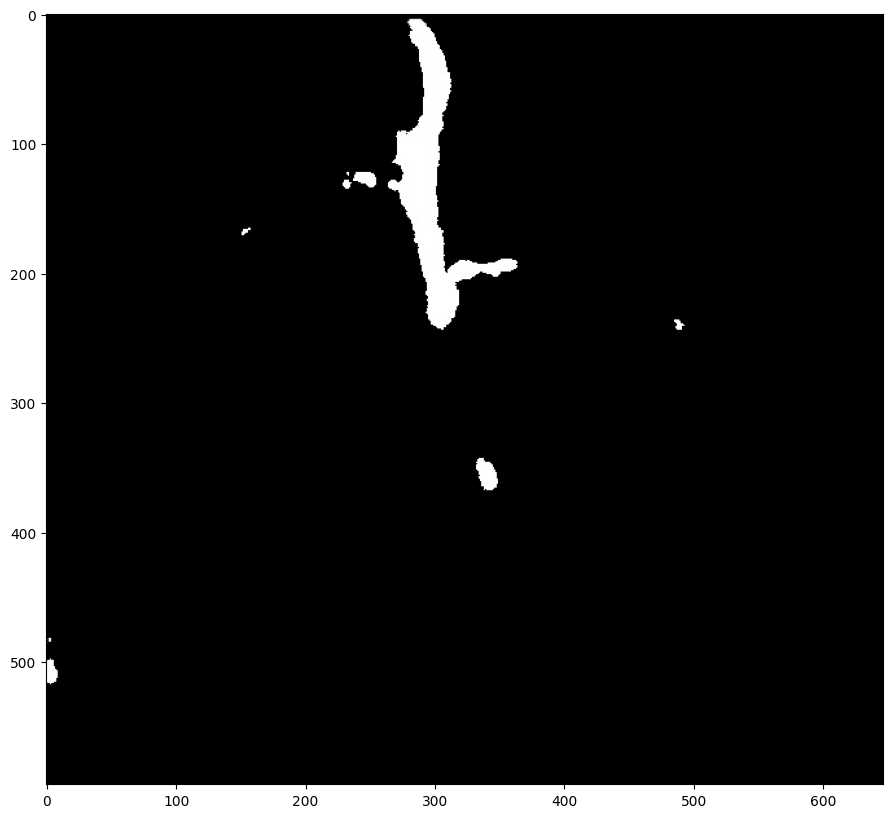

Isotropic closing of segmentation image


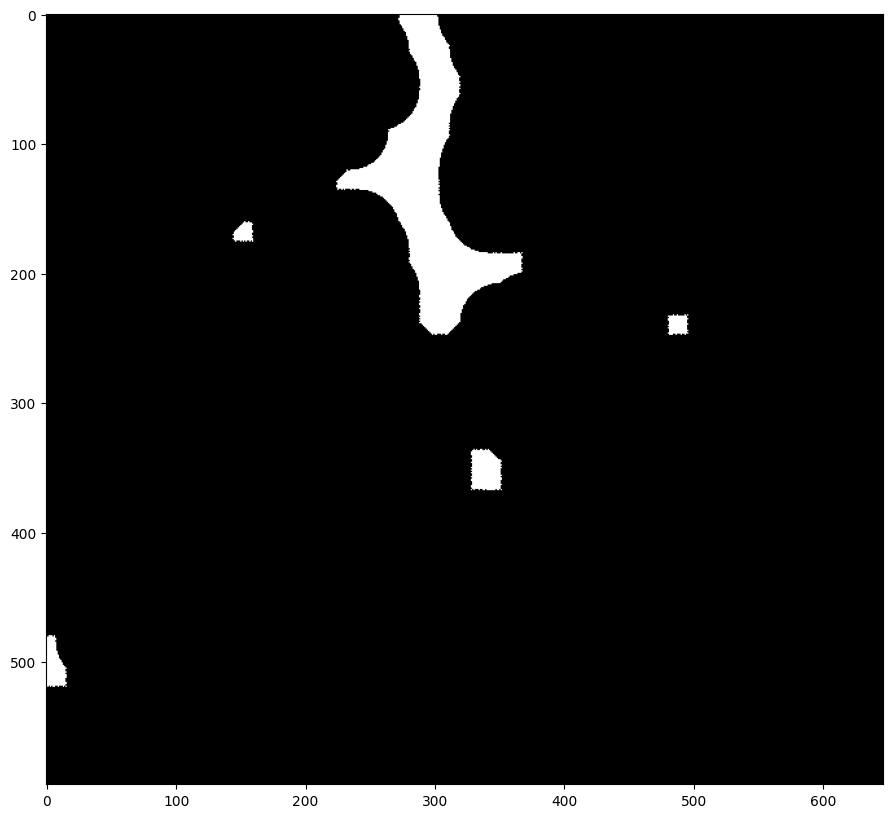

Number of contours: 5
Contour length: 110.66904664039612
Contour area: 411.5
Convex hull area: 474.5


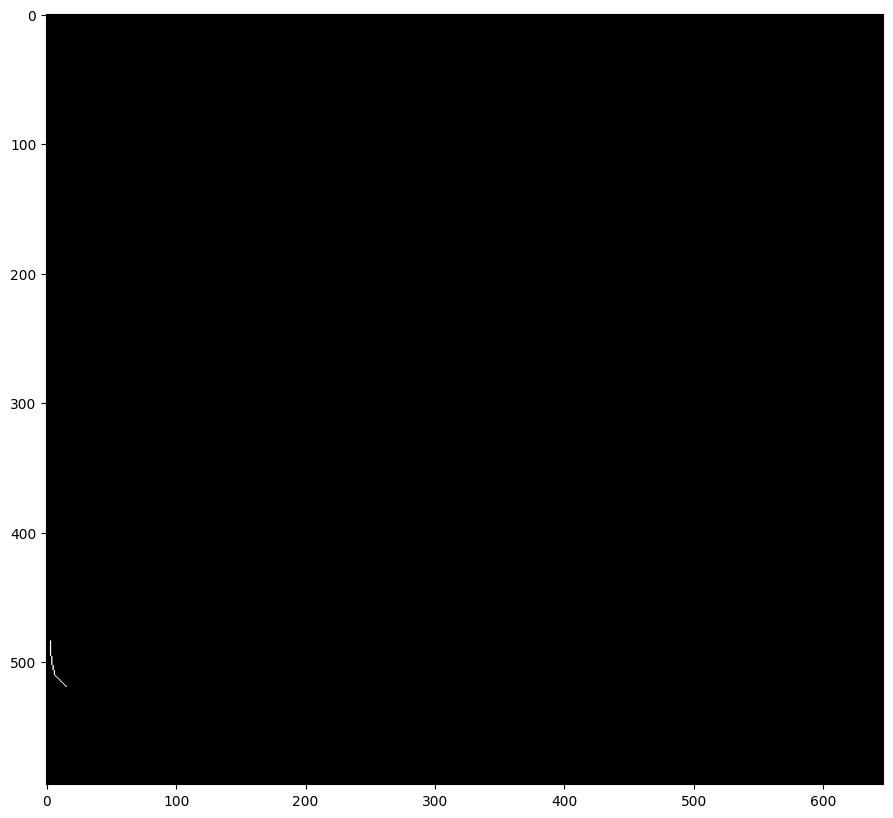

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.8672286617492097 -> no intersection in this contour
Contour length: 122.26702582836151
Contour area: 616.5
Convex hull area: 666.5


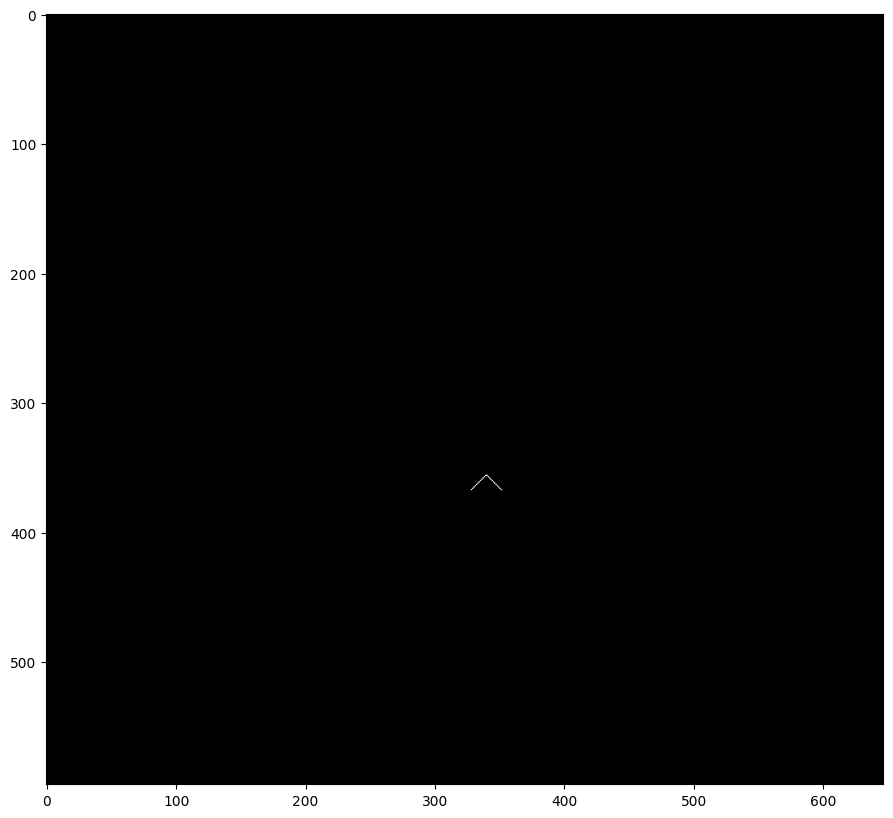

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.9249812453113279 -> no intersection in this contour
Contour length: 69.84061968326569
Contour area: 186.5
Convex hull area: 221.5


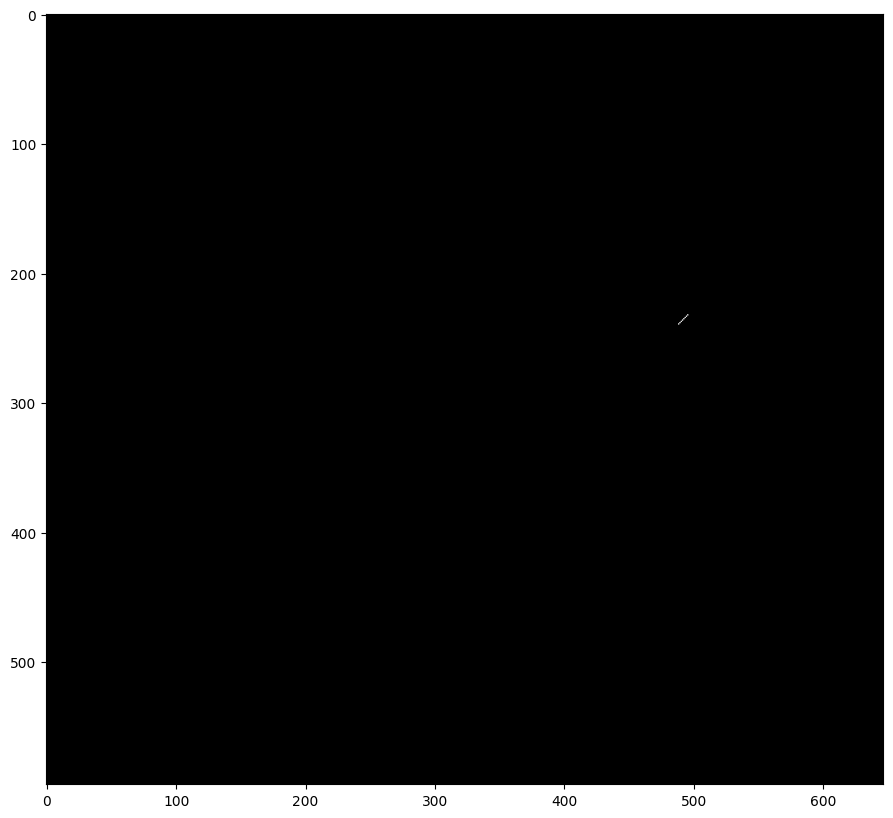

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.8419864559819413 -> no intersection in this contour
Contour length: 60.66904675960541
Contour area: 159.5
Convex hull area: 179.5


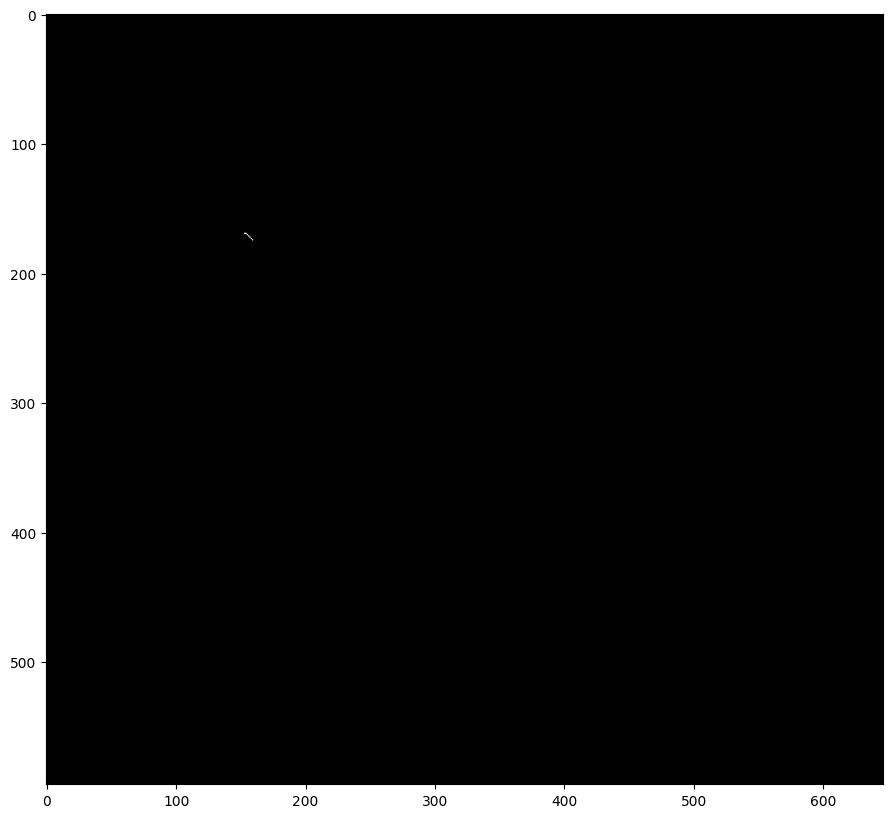

Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.8885793871866295 -> no intersection in this contour
Contour length: 769.0924904346466
Contour area: 10303.0
Convex hull area: 20832.5


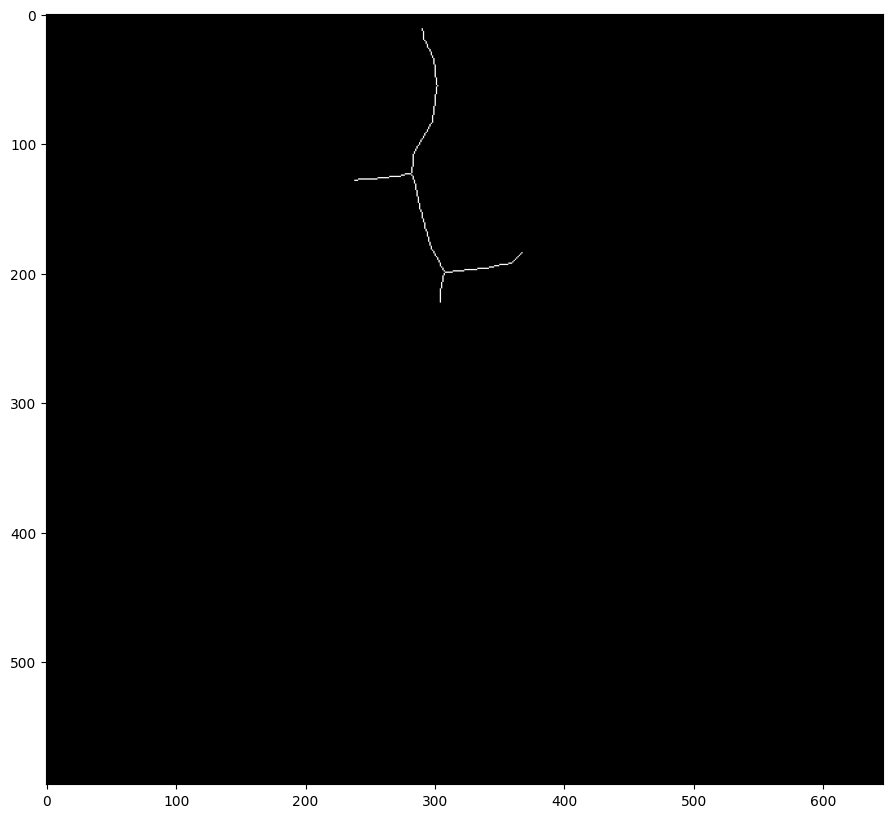

Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton
Solidity = 0.49456378255130207 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images
Road neighbour pixels: [(14, 15), (16, 14), (16, 16)]
Number of roads that intersect in this intersection: 3
Patch:


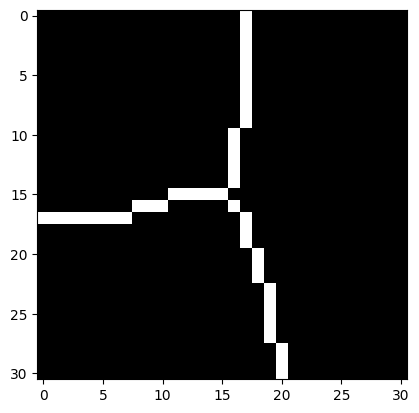

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0  

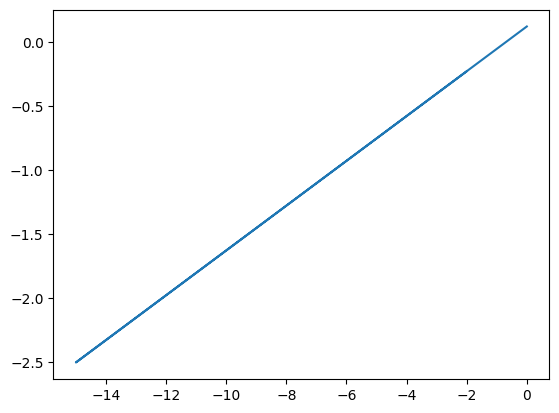

Direction is: 189.9262455066517
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 1.  5.]
 [ 2.  6.]
 [ 2.  7.]
 [ 2.  8.]
 [ 2.  9.]
 [ 2. 10.]
 [ 2. 11.]
 [ 2. 12.]
 [ 2. 13.]
 [ 2. 14.]
 [ 2. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 6.31578947 -2.36842105]


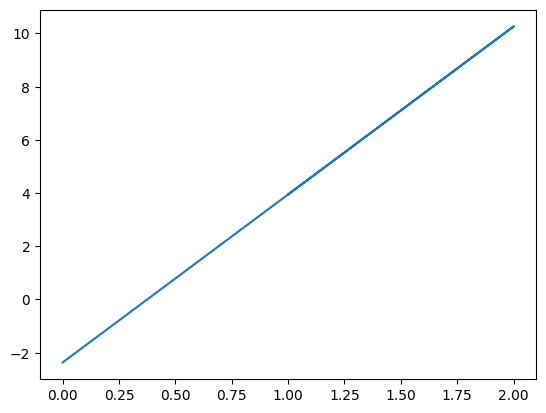

Direction is: 81.00285657893494
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  2.  -3.]
 [  2.  -4.]
 [  3.  -5.]
 [  3.  -6.]
 [  3.  -7.]
 [  4.  -8.]
 [  4.  -9.]
 [  4. -10.]
 [  4. -11.]
 [  4. -12.]
 [  5. -13.]
 [  5. -14.]
 [  5. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-3.0982659   2.37572254]


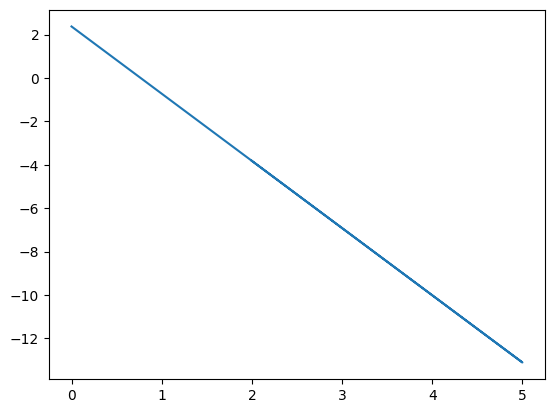

Direction is: 287.8880657955038
Sorted vector of angles: [81.00285657893494, 189.9262455066517, 287.8880657955038]
Road neighbour pixels: [(14, 14), (14, 16), (16, 15)]
Number of roads that intersect in this intersection: 3
Patch:


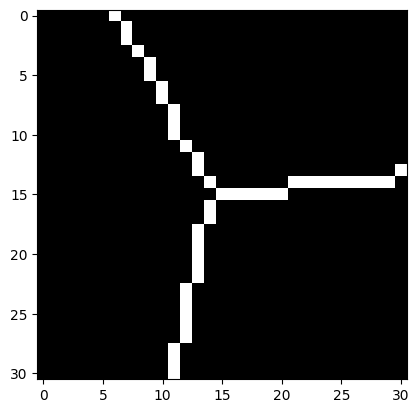

[[  0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0
    0   0   0   0   0  

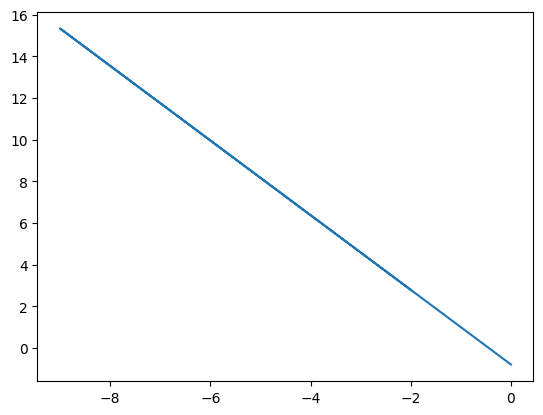

Direction is: 119.15259017305127
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -2.  -3.]
 [ -2.  -4.]
 [ -2.  -5.]
 [ -2.  -6.]
 [ -2.  -7.]
 [ -3.  -8.]
 [ -3.  -9.]
 [ -3. -10.]
 [ -3. -11.]
 [ -3. -12.]
 [ -4. -13.]
 [ -4. -14.]
 [ -4. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [3.93730408 2.09717868]


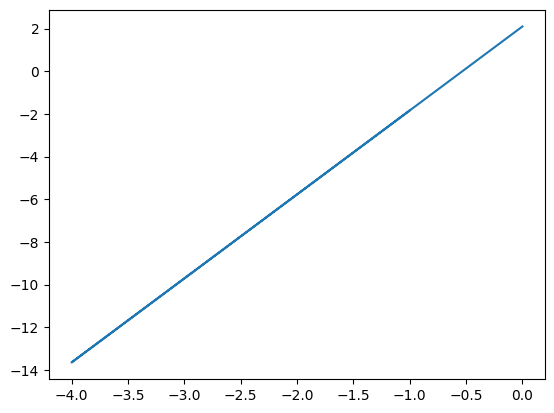

Direction is: 255.74928708826928
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  0.]
 [ 3.  0.]
 [ 4.  0.]
 [ 5.  0.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8.  1.]
 [ 9.  1.]
 [10.  1.]
 [11.  1.]
 [12.  1.]
 [13.  1.]
 [14.  1.]
 [15.  2.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 0.11029412 -0.13970588]


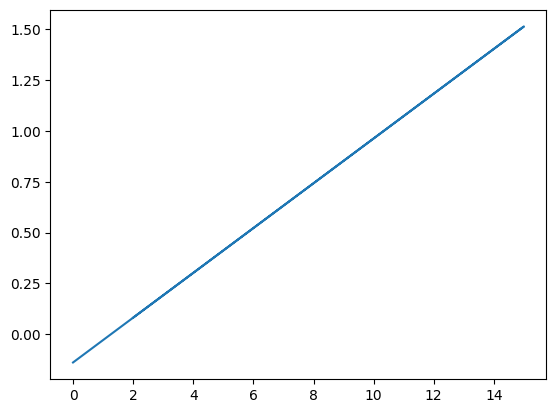

Direction is: 6.293948188951081
Sorted vector of angles: [6.293948188951081, 119.15259017305127, 255.74928708826928]
Array of descriptors: [[81.00285657893494, 189.9262455066517, 287.8880657955038], [6.293948188951081, 119.15259017305127, 255.74928708826928]]


In [22]:
segm_img_des = find_descriptors_in_segmentation_image_without_pruning(sem_segm_img_path)
print(f"Array of descriptors: {segm_img_des}")

In [23]:
def find_descriptors_in_mapbox_image(img_path, image_name) : 
    print(f"Finding descriptors in mapbox image {image_name}")
    
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    # print("Cropped mapbox image")
    # plot_image(cropped_img_bgr)

    # print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    # plot_image(thresh_bgr)

    img_bgr_copy = img_bgr.copy()

    contours, hierarchy = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(f"Number of contours: {len(contours)}")
    cv2.drawContours(img_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        # print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        # print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            # print(f"Convex hull area: {convex_hull_area}")
            cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            if convex_hull_area != 0 :
                solidity = contour_area / convex_hull_area
            else :
                solidity = 0

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")

            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        # print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        # print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        # print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        # print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

**************************************************
Mapbox image: 50.7896086_3.5606402.png
**************************************************
Finding descriptors in mapbox image 50.7896086_3.5606402.png
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.42768599457137363 -> no intersection in this contour
Descriptors: None for mapbox image 50.7896086_3.5606402.png
**************************************************
Mapbox image: 50.790311_3.5601028.png
**************************************************
Finding descriptors in mapbox image 50.790311_3.5601028.png
Getting intersections in skeleton (more than 2 neighbours)
1 intersections found in the skeleton
Solidity = 0.20615043551854043 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images


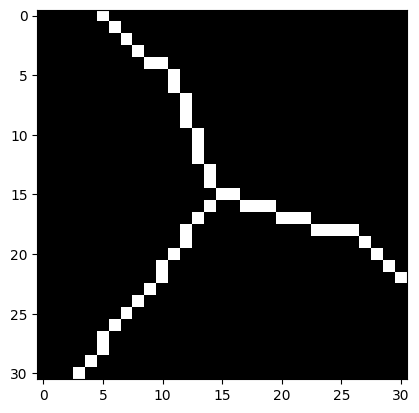

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.   2.]
 [ -2.   3.]
 [ -2.   4.]
 [ -2.   5.]
 [ -3.   6.]
 [ -3.   7.]
 [ -3.   8.]
 [ -4.   9.]
 [ -4.  10.]
 [ -5.  11.]
 [ -6.  11.]
 [ -7.  12.]
 [ -8.  13.]
 [ -9.  14.]
 [-10.  15.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-1.51388889  1.47222222]


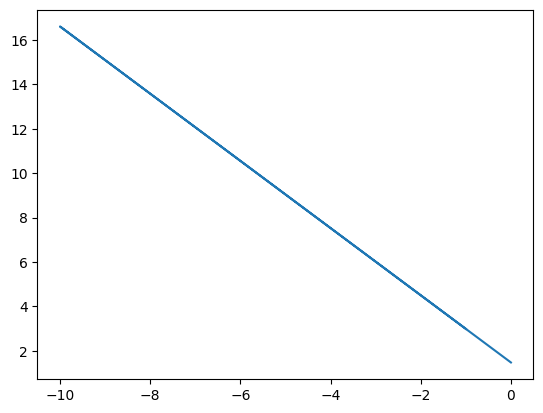

Direction is: 123.44677480771495
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -3.  -4.]
 [ -4.  -5.]
 [ -5.  -6.]
 [ -5.  -7.]
 [ -6.  -8.]
 [ -7.  -9.]
 [ -8. -10.]
 [ -9. -11.]
 [-10. -12.]
 [-10. -13.]
 [-11. -14.]
 [-12. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [1.27403846 0.14423077]


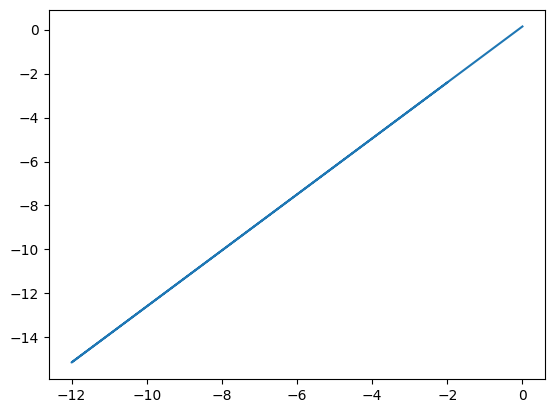

Direction is: 231.8714308524785
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -1.]
 [ 3. -1.]
 [ 4. -1.]
 [ 5. -2.]
 [ 6. -2.]
 [ 7. -2.]
 [ 8. -3.]
 [ 9. -3.]
 [10. -3.]
 [11. -3.]
 [12. -4.]
 [13. -5.]
 [14. -6.]
 [15. -7.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.40735294  0.36764706]


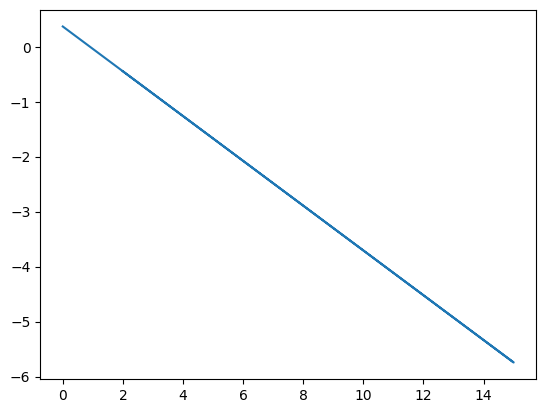

Direction is: 337.83633067530025
Sorted vector of angles: [123.44677480771495, 231.8714308524785, 337.83633067530025]
Descriptors: [[123.44677480771495, 231.8714308524785, 337.83633067530025]] for mapbox image 50.790311_3.5601028.png
Number of descriptors: 1
Descriptor of segmentation image:
[81.00285657893494, 189.9262455066517, 287.8880657955038]
Descriptor of mapbox image:
[123.44677480771495, 231.8714308524785, 337.83633067530025]
x = 81.00285657893494, y = 123.44677480771495
x = 189.9262455066517, y = 231.8714308524785
x = 287.8880657955038, y = 337.83633067530025
Result = 77.8184678132989
Descriptor of segmentation image:
[6.293948188951081, 119.15259017305127, 255.74928708826928]
Descriptor of mapbox image:
[123.44677480771495, 231.8714308524785, 337.83633067530025]
x = 6.293948188951081, y = 123.44677480771495
x = 119.15259017305127, y = 231.8714308524785
x = 255.74928708826928, y = 337.83633067530025
Result = 182.12249875767512
*************************************************

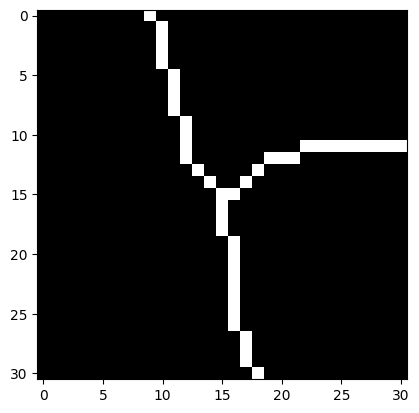

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-2.  2.]
 [-3.  3.]
 [-3.  4.]
 [-3.  5.]
 [-3.  6.]
 [-4.  7.]
 [-4.  8.]
 [-4.  9.]
 [-4. 10.]
 [-5. 11.]
 [-5. 12.]
 [-5. 13.]
 [-5. 14.]
 [-6. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [-2.83360791 -2.59472817]


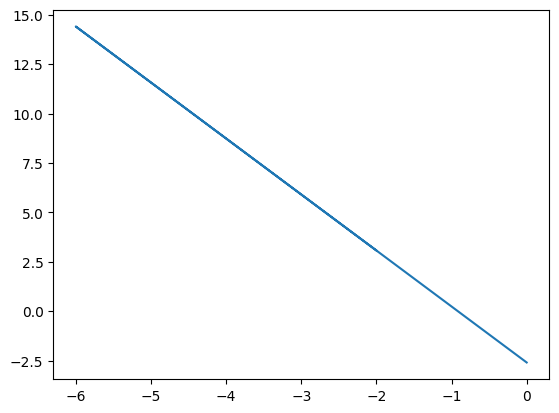

Direction is: 109.43829236179654
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  1.  -7.]
 [  1.  -8.]
 [  1.  -9.]
 [  1. -10.]
 [  1. -11.]
 [  2. -12.]
 [  2. -13.]
 [  2. -14.]
 [  3. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [-5.07428571 -2.10857143]


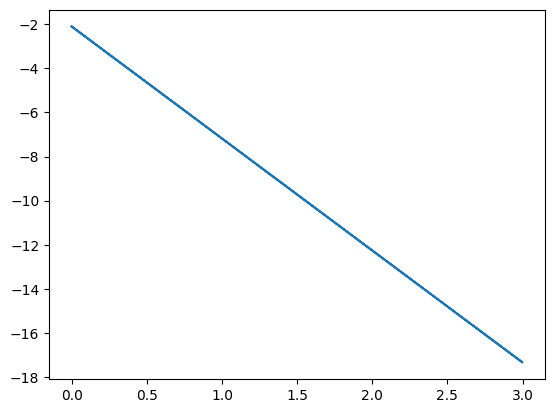

Direction is: 281.1485363388998
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  2.]
 [ 4.  3.]
 [ 5.  3.]
 [ 6.  3.]
 [ 7.  4.]
 [ 8.  4.]
 [ 9.  4.]
 [10.  4.]
 [11.  4.]
 [12.  4.]
 [13.  4.]
 [14.  4.]
 [15.  4.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [0.26176471 1.03676471]


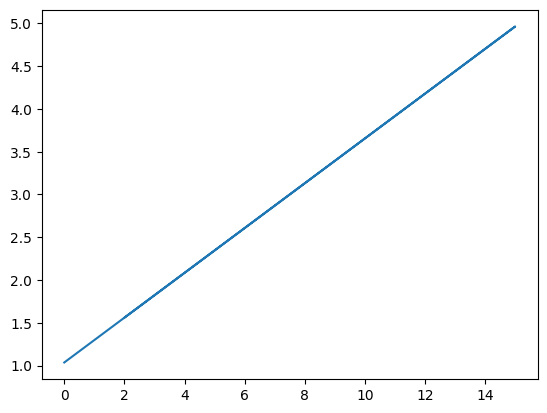

Direction is: 14.668883368895717
Sorted vector of angles: [14.668883368895717, 109.43829236179654, 281.1485363388998]
Descriptors: [[14.668883368895717, 109.43829236179654, 281.1485363388998]] for mapbox image 50.7900181_3.5582648.png
Number of descriptors: 1
Descriptor of segmentation image:
[81.00285657893494, 189.9262455066517, 287.8880657955038]
Descriptor of mapbox image:
[14.668883368895717, 109.43829236179654, 281.1485363388998]
x = 81.00285657893494, y = 14.668883368895717
x = 189.9262455066517, y = 109.43829236179654
x = 287.8880657955038, y = 281.1485363388998
Result = 104.51759593759814
Descriptor of segmentation image:
[6.293948188951081, 119.15259017305127, 255.74928708826928]
Descriptor of mapbox image:
[14.668883368895717, 109.43829236179654, 281.1485363388998]
x = 6.293948188951081, y = 14.668883368895717
x = 119.15259017305127, y = 109.43829236179654
x = 255.74928708826928, y = 281.1485363388998
Result = 28.453980103487776
**********************************************

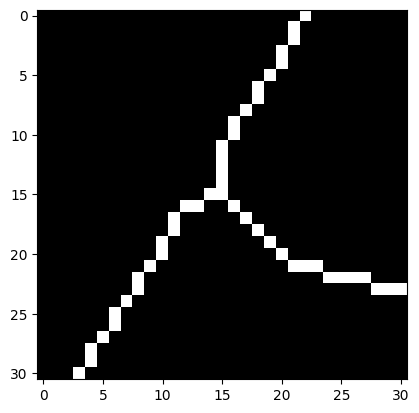

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -1.]
 [ -4.  -2.]
 [ -4.  -3.]
 [ -5.  -4.]
 [ -5.  -5.]
 [ -6.  -6.]
 [ -7.  -7.]
 [ -7.  -8.]
 [ -8.  -9.]
 [ -9. -10.]
 [ -9. -11.]
 [-10. -12.]
 [-11. -13.]
 [-11. -14.]
 [-12. -15.]
 [ -1.   0.]
 [  0.   0.]]
Line: [1.37575758 1.99090909]


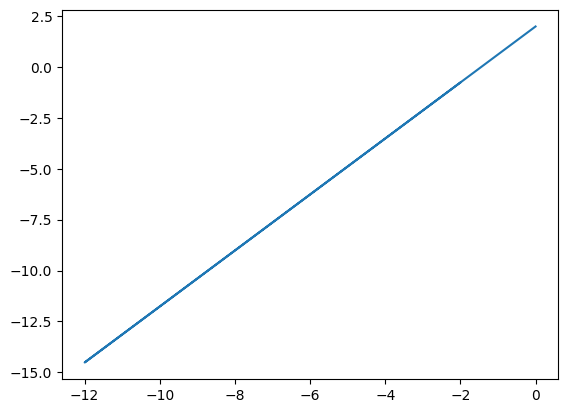

Direction is: 233.98763729820848
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 1.  5.]
 [ 1.  6.]
 [ 2.  7.]
 [ 3.  8.]
 [ 3.  9.]
 [ 4. 10.]
 [ 5. 11.]
 [ 5. 12.]
 [ 6. 13.]
 [ 6. 14.]
 [ 7. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [1.8388998  2.55795678]


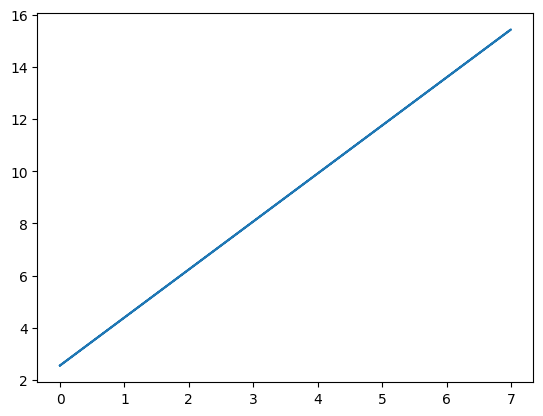

Direction is: 61.4625012123298
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -4.]
 [ 5. -5.]
 [ 6. -6.]
 [ 7. -6.]
 [ 8. -6.]
 [ 9. -7.]
 [10. -7.]
 [11. -7.]
 [12. -7.]
 [13. -8.]
 [14. -8.]
 [15. -8.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.51029412 -1.48529412]


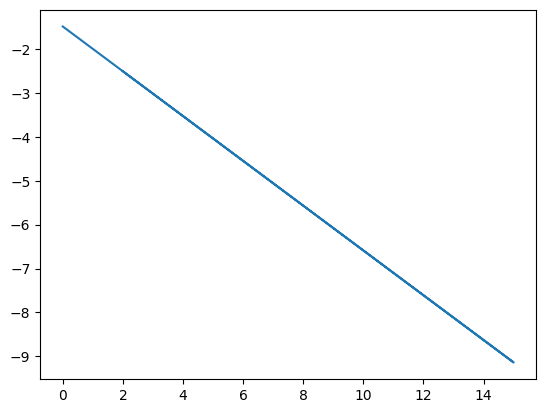

Direction is: 332.9650466972175
Sorted vector of angles: [61.4625012123298, 233.98763729820848, 332.9650466972175]
Descriptors: [[61.4625012123298, 233.98763729820848, 332.9650466972175]] for mapbox image 50.7901335_3.5639848.png
Number of descriptors: 1
Descriptor of segmentation image:
[81.00285657893494, 189.9262455066517, 287.8880657955038]
Descriptor of mapbox image:
[61.4625012123298, 233.98763729820848, 332.9650466972175]
x = 81.00285657893494, y = 61.4625012123298
x = 189.9262455066517, y = 233.98763729820848
x = 287.8880657955038, y = 332.9650466972175
Result = 65.99368107384026
Descriptor of segmentation image:
[6.293948188951081, 119.15259017305127, 255.74928708826928]
Descriptor of mapbox image:
[61.4625012123298, 233.98763729820848, 332.9650466972175]
x = 6.293948188951081, y = 61.4625012123298
x = 119.15259017305127, y = 233.98763729820848
x = 255.74928708826928, y = 332.9650466972175
Result = 148.97291976368493
**************************************************
Mapbox im

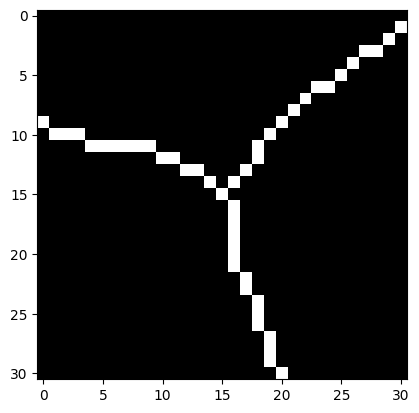

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   2.]
 [ -4.   3.]
 [ -5.   3.]
 [ -6.   4.]
 [ -7.   4.]
 [ -8.   4.]
 [ -9.   4.]
 [-10.   4.]
 [-11.   4.]
 [-12.   5.]
 [-13.   5.]
 [-14.   5.]
 [-15.   6.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.31470588  1.13970588]


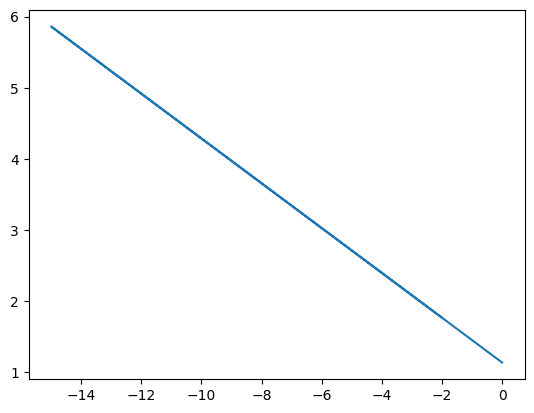

Direction is: 162.5309044968367
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 3.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  9.]
 [ 9.  9.]
 [10. 10.]
 [11. 11.]
 [12. 12.]
 [13. 12.]
 [14. 13.]
 [15. 14.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.91448231 0.79521625]


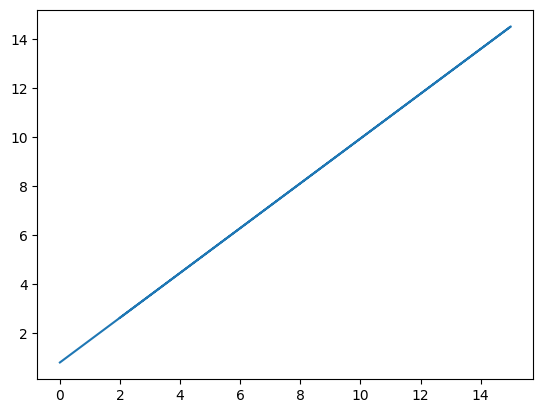

Direction is: 42.44236449049682
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -2.]
 [  1.  -3.]
 [  1.  -4.]
 [  1.  -5.]
 [  1.  -6.]
 [  2.  -7.]
 [  2.  -8.]
 [  3.  -9.]
 [  3. -10.]
 [  3. -11.]
 [  4. -12.]
 [  4. -13.]
 [  4. -14.]
 [  5. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-3.09090909 -0.54545455]


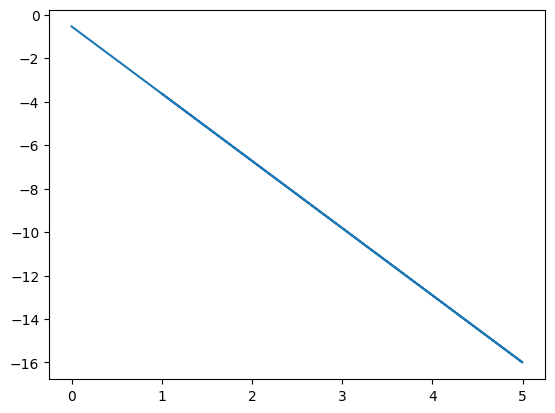

Direction is: 287.92791976200726
Sorted vector of angles: [42.44236449049682, 162.5309044968367, 287.92791976200726]
Descriptors: [[42.44236449049682, 162.5309044968367, 287.92791976200726]] for mapbox image 50.7878132_3.5608475.png
Number of descriptors: 1
Descriptor of segmentation image:
[81.00285657893494, 189.9262455066517, 287.8880657955038]
Descriptor of mapbox image:
[42.44236449049682, 162.5309044968367, 287.92791976200726]
x = 81.00285657893494, y = 42.44236449049682
x = 189.9262455066517, y = 162.5309044968367
x = 287.8880657955038, y = 287.92791976200726
Result = 47.30135143402559
Descriptor of segmentation image:
[6.293948188951081, 119.15259017305127, 255.74928708826928]
Descriptor of mapbox image:
[42.44236449049682, 162.5309044968367, 287.92791976200726]
x = 6.293948188951081, y = 42.44236449049682
x = 119.15259017305127, y = 162.5309044968367
x = 255.74928708826928, y = 287.92791976200726
Result = 64.99115751726804
**************************************************
Map

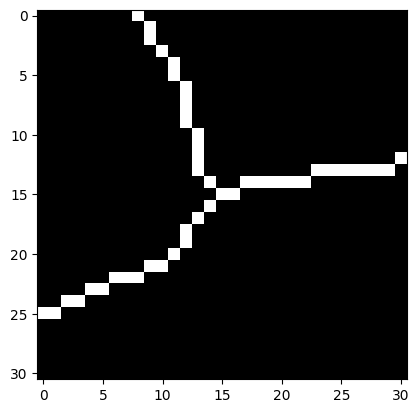

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-2.  2.]
 [-2.  3.]
 [-2.  4.]
 [-2.  5.]
 [-3.  6.]
 [-3.  7.]
 [-3.  8.]
 [-3.  9.]
 [-4. 10.]
 [-4. 11.]
 [-5. 12.]
 [-6. 13.]
 [-6. 14.]
 [-7. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [-2.39007892 -0.41713641]


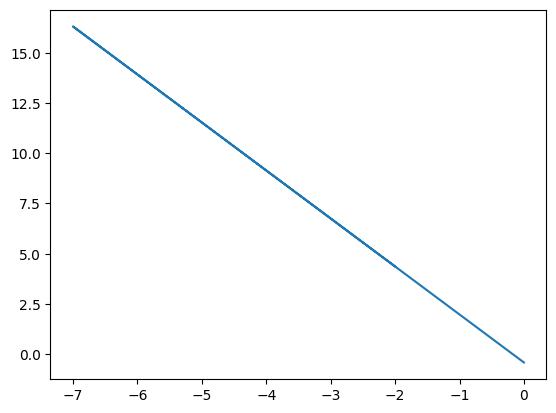

Direction is: 112.70425030287754
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -3.  -4.]
 [ -4.  -5.]
 [ -5.  -6.]
 [ -6.  -6.]
 [ -7.  -7.]
 [ -8.  -7.]
 [ -9.  -7.]
 [-10.  -8.]
 [-11.  -8.]
 [-12.  -9.]
 [-13.  -9.]
 [-14. -10.]
 [-15. -10.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.62663827 -1.46608781]


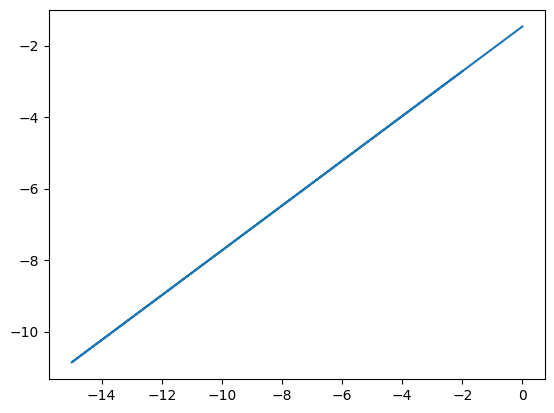

Direction is: 212.07283262821164
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  1.]
 [ 4.  1.]
 [ 5.  1.]
 [ 6.  1.]
 [ 7.  1.]
 [ 8.  2.]
 [ 9.  2.]
 [10.  2.]
 [11.  2.]
 [12.  2.]
 [13.  2.]
 [14.  2.]
 [15.  3.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [0.15735294 0.25735294]


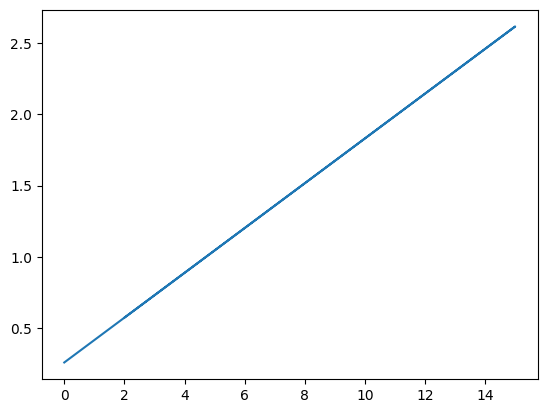

Direction is: 8.942336574927541
Sorted vector of angles: [8.942336574927541, 112.70425030287754, 212.07283262821164]
Descriptors: [[8.942336574927541, 112.70425030287754, 212.07283262821164]] for mapbox image 50.7904954_3.5617855.png
Number of descriptors: 1
Descriptor of segmentation image:
[81.00285657893494, 189.9262455066517, 287.8880657955038]
Descriptor of mapbox image:
[8.942336574927541, 112.70425030287754, 212.07283262821164]
x = 81.00285657893494, y = 8.942336574927541
x = 189.9262455066517, y = 112.70425030287754
x = 287.8880657955038, y = 212.07283262821164
Result = 130.01501708153003
Descriptor of segmentation image:
[6.293948188951081, 119.15259017305127, 255.74928708826928]
Descriptor of mapbox image:
[8.942336574927541, 112.70425030287754, 212.07283262821164]
x = 6.293948188951081, y = 8.942336574927541
x = 119.15259017305127, y = 112.70425030287754
x = 255.74928708826928, y = 212.07283262821164
Result = 44.22926318994853
************************************************

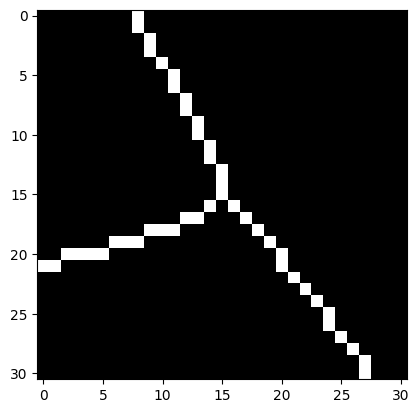

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -2.]
 [ -4.  -3.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -4.]
 [ -8.  -4.]
 [ -9.  -4.]
 [-10.  -5.]
 [-11.  -5.]
 [-12.  -5.]
 [-13.  -5.]
 [-14.  -6.]
 [-15.  -6.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.35588235 -0.95588235]


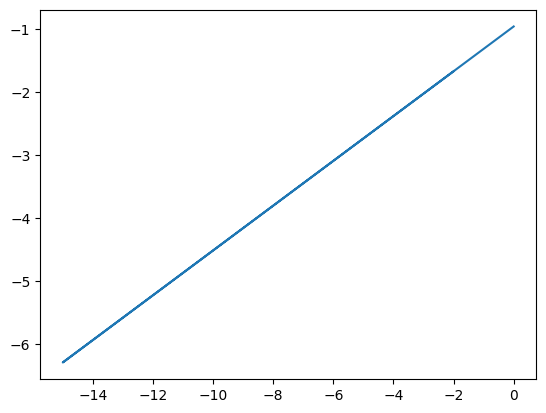

Direction is: 199.58974679174284
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [-1.  3.]
 [-1.  4.]
 [-2.  5.]
 [-2.  6.]
 [-3.  7.]
 [-3.  8.]
 [-4.  9.]
 [-4. 10.]
 [-5. 11.]
 [-6. 12.]
 [-6. 13.]
 [-7. 14.]
 [-7. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-1.89858012  1.44827586]


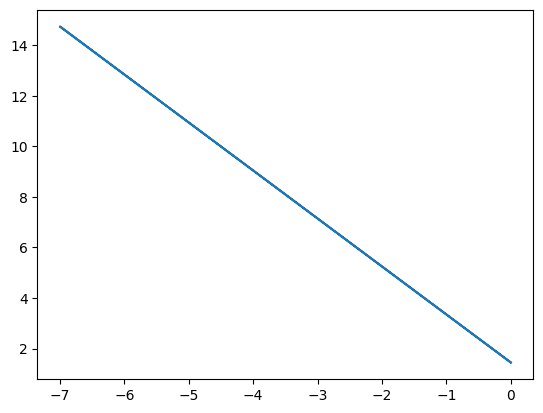

Direction is: 117.77619801251967
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  5.  -6.]
 [  6.  -7.]
 [  7.  -8.]
 [  8.  -9.]
 [  9. -10.]
 [  9. -11.]
 [ 10. -12.]
 [ 11. -13.]
 [ 12. -14.]
 [ 12. -15.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-1.22767857  0.47991071]


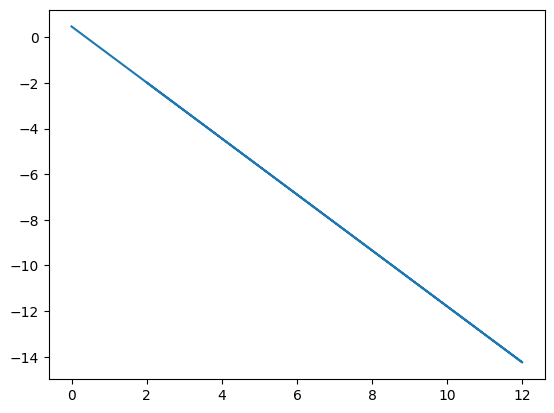

Direction is: 309.16438155515846
Sorted vector of angles: [117.77619801251967, 199.58974679174284, 309.16438155515846]
Descriptors: [[117.77619801251967, 199.58974679174284, 309.16438155515846]] for mapbox image 50.7889395_3.5632202.png
Number of descriptors: 1
Descriptor of segmentation image:
[81.00285657893494, 189.9262455066517, 287.8880657955038]
Descriptor of mapbox image:
[117.77619801251967, 199.58974679174284, 309.16438155515846]
x = 81.00285657893494, y = 117.77619801251967
x = 189.9262455066517, y = 199.58974679174284
x = 287.8880657955038, y = 309.16438155515846
Result = 43.56998404386312
Descriptor of segmentation image:
[6.293948188951081, 119.15259017305127, 255.74928708826928]
Descriptor of mapbox image:
[117.77619801251967, 199.58974679174284, 309.16438155515846]
x = 6.293948188951081, y = 117.77619801251967
x = 119.15259017305127, y = 199.58974679174284
x = 255.74928708826928, y = 309.16438155515846
Result = 147.48423816642637
*****************************************

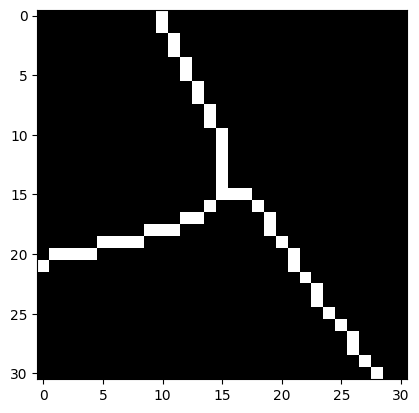

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -2.]
 [ -4.  -3.]
 [ -5.  -3.]
 [ -6.  -3.]
 [ -7.  -4.]
 [ -8.  -4.]
 [ -9.  -4.]
 [-10.  -4.]
 [-11.  -5.]
 [-12.  -5.]
 [-13.  -5.]
 [-14.  -5.]
 [-15.  -6.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.32941176 -1.02941176]


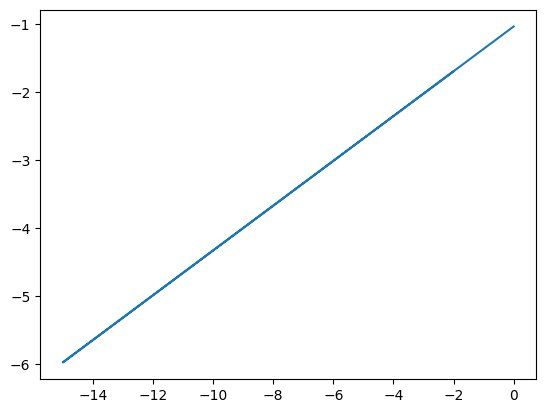

Direction is: 198.23249108070382
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [-1.  6.]
 [-1.  7.]
 [-2.  8.]
 [-2.  9.]
 [-3. 10.]
 [-3. 11.]
 [-4. 12.]
 [-4. 13.]
 [-5. 14.]
 [-5. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-2.41860465  2.96511628]


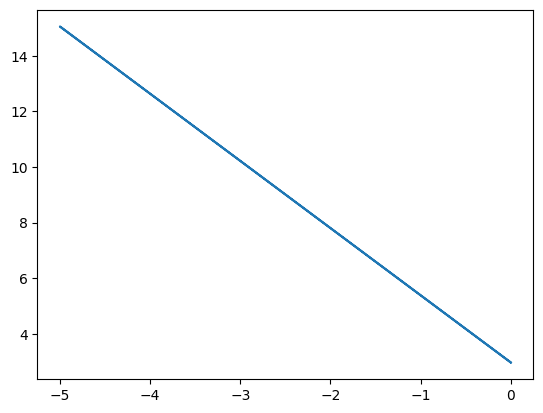

Direction is: 112.46321248940716
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.   0.]
 [  3.  -1.]
 [  4.  -2.]
 [  4.  -3.]
 [  5.  -4.]
 [  6.  -5.]
 [  6.  -6.]
 [  7.  -7.]
 [  8.  -8.]
 [  8.  -9.]
 [  9. -10.]
 [ 10. -11.]
 [ 11. -12.]
 [ 11. -13.]
 [ 12. -14.]
 [ 13. -15.]
 [  1.   0.]
 [  0.   0.]]
Line: [-1.296875    1.97916667]


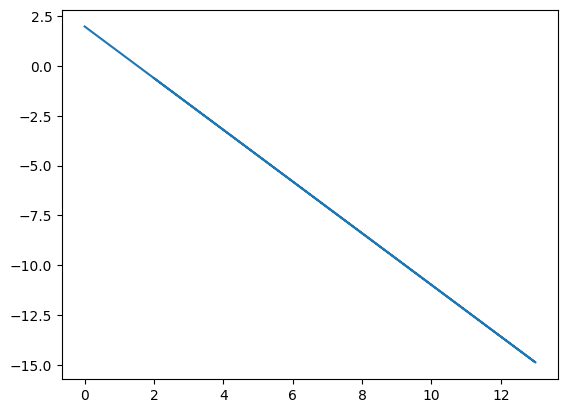

Direction is: 307.63525375501735
Sorted vector of angles: [112.46321248940716, 198.23249108070382, 307.63525375501735]
Descriptors: [[112.46321248940716, 198.23249108070382, 307.63525375501735]] for mapbox image 50.7888821_3.5635942.png
Number of descriptors: 1
Descriptor of segmentation image:
[81.00285657893494, 189.9262455066517, 287.8880657955038]
Descriptor of mapbox image:
[112.46321248940716, 198.23249108070382, 307.63525375501735]
x = 81.00285657893494, y = 112.46321248940716
x = 189.9262455066517, y = 198.23249108070382
x = 287.8880657955038, y = 307.63525375501735
Result = 38.06178059232649
Descriptor of segmentation image:
[6.293948188951081, 119.15259017305127, 255.74928708826928]
Descriptor of mapbox image:
[112.46321248940716, 198.23249108070382, 307.63525375501735]
x = 6.293948188951081, y = 112.46321248940716
x = 119.15259017305127, y = 198.23249108070382
x = 255.74928708826928, y = 307.63525375501735
Result = 142.1889480466296
Lowest score = 112.29250895129363 with map

In [24]:
best_mb_image = None
lowest_score = 1000

for mb_image in os.listdir(mapbox_imgs_dir_path) : 
    score = 0
    mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)
    print(50*"*")
    print(f"Mapbox image: {mb_image}")
    print(50*"*")
    mb_image_bgr = cv2.imread(mb_image_path)
    des = find_descriptors_in_mapbox_image(mb_image_path, mb_image)
    print(f"Descriptors: {des} for mapbox image {mb_image}")

    # matching process
    if des is not None and segm_img_des is not None :
        print(f"Number of descriptors: {len(des)}")
        for des_segm in segm_img_des :
            best_result_per_des = 1000 # best descriptor match for descriptor des_segm of segmentation image
            print(f"Descriptor of segmentation image:")
            print(des_segm)
            for des_ in des :
                print(f"Descriptor of mapbox image:")
                print(des_)

                if len(des_segm) == len(des_) : 
                    result = 0
                    for x, y in zip(des_segm, des_) :
                        print(f"x = {x}, y = {y}")
                        result += (x-y)**2
                    result = math.sqrt(result)
                elif len(des_) > len(des_segm) :
                    for x in des_segm : 
                        best_diff = 1000
                        for y in des_ :
                            diff = abs(x-y)
                            if diff < best_diff :
                                best_diff = diff
                        result += best_diff**2
                    result = math.sqrt(result)
                else :
                    # this can't be the case 
                    continue

                print(f"Result = {result}")
            
                if result < best_result_per_des :
                    best_result_per_des = result
            
            score += best_result_per_des
        
        if score < lowest_score :
            lowest_score = score
            best_mb_image = mb_image
    else:
        continue

print(f"Lowest score = {lowest_score} with mapbox image {best_mb_image}")